In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#!pip install statsmodels

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from urllib.parse import urlencode
from configparser import ConfigParser
from scipy import stats
import itertools
import statsmodels.api as sm
import statsmodels.tsa as ts
import warnings
import matplotlib.pyplot as plt
%pylab inline
from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Populating the interactive namespace from numpy and matplotlib


C:\Users\nigel\anaconda3\envs\jupyterlab\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
currency_data = pd.read_csv('02_Brexit_Tweets_19_20/yahoo_GBPEUR.csv',usecols=['Date','Close'], index_col=['Date'], parse_dates= True, dayfirst=True)
currency_data.head()
currency_data.shape

,Close
Date,
2019-01-01,1.10790
2019-01-02,1.11264
2019-01-03,1.10570
2019-01-04,1.10851
2019-01-07,1.11593


(504, 1)

In [5]:
currency_data.index.name = 'Date'
currency_data.columns = ['GBP']

In [6]:
currency_data.index = pd.to_datetime(currency_data.index)

In [7]:
new_dates = pd.date_range(currency_data.index.min(), currency_data.index.max())

In [8]:
currency_data = currency_data.reindex(new_dates, method = 'nearest')

In [9]:
currency_data.head()
currency_data.shape

,GBP
2019-01-01,1.10790
2019-01-02,1.11264
2019-01-03,1.10570
2019-01-04,1.10851
2019-01-05,1.10851


(732, 1)

<Figure size 1512x648 with 0 Axes>

Text(0.5, 1.0, 'GBP exchange rate')

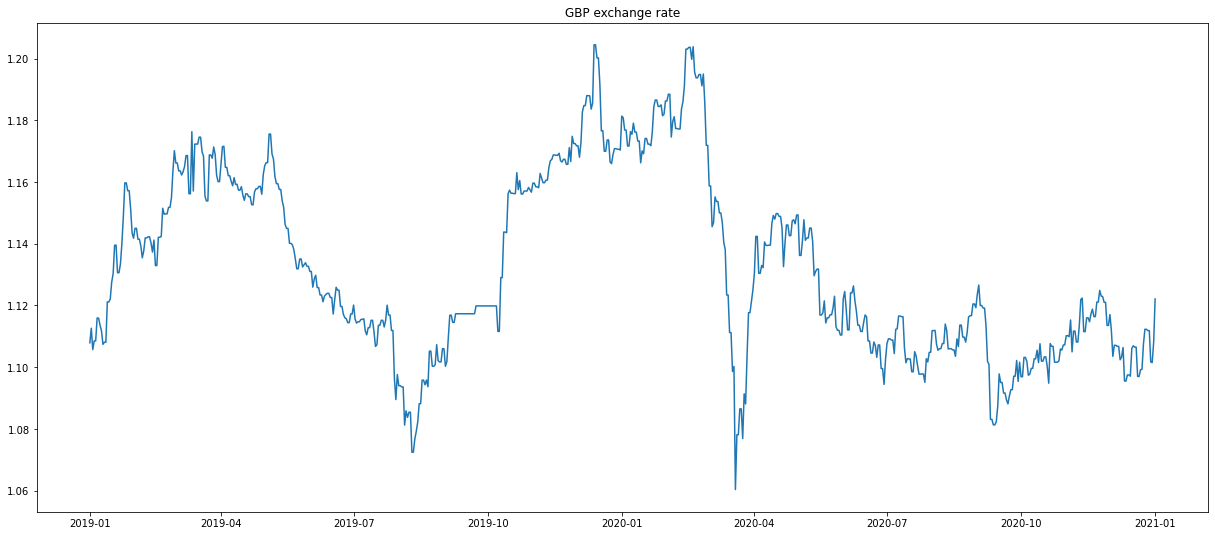

In [13]:
plt.figure(figsize(21,9))
plt.plot(currency_data)
plt.title("GBP exchange rate")

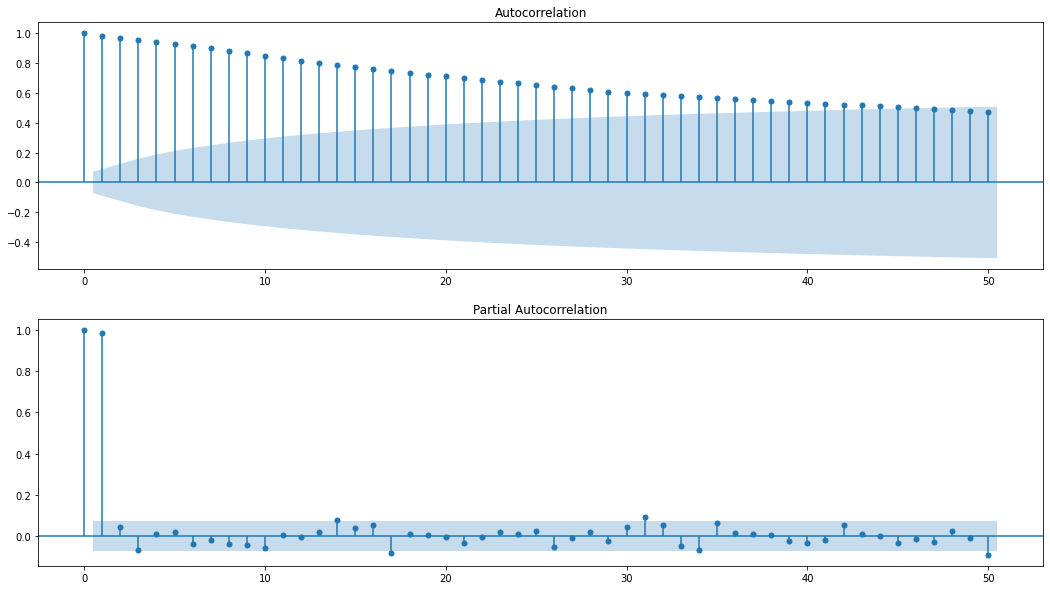

In [12]:
_ = plt.figure(figsize=(18,10))
ax_1 = plt.subplot(2,1,1)
_ = sm.graphics.tsa.plot_acf(currency_data.GBP.values.squeeze(), lags=50, ax=ax_1)
ax_2 = plt.subplot(2,1,2)
_ = sm.graphics.tsa.plot_pacf(currency_data.GBP.values.squeeze(), lags=50, ax=ax_2)

Dickey-Fuller criterion p=0.159995


<Figure size 1296x720 with 0 Axes>

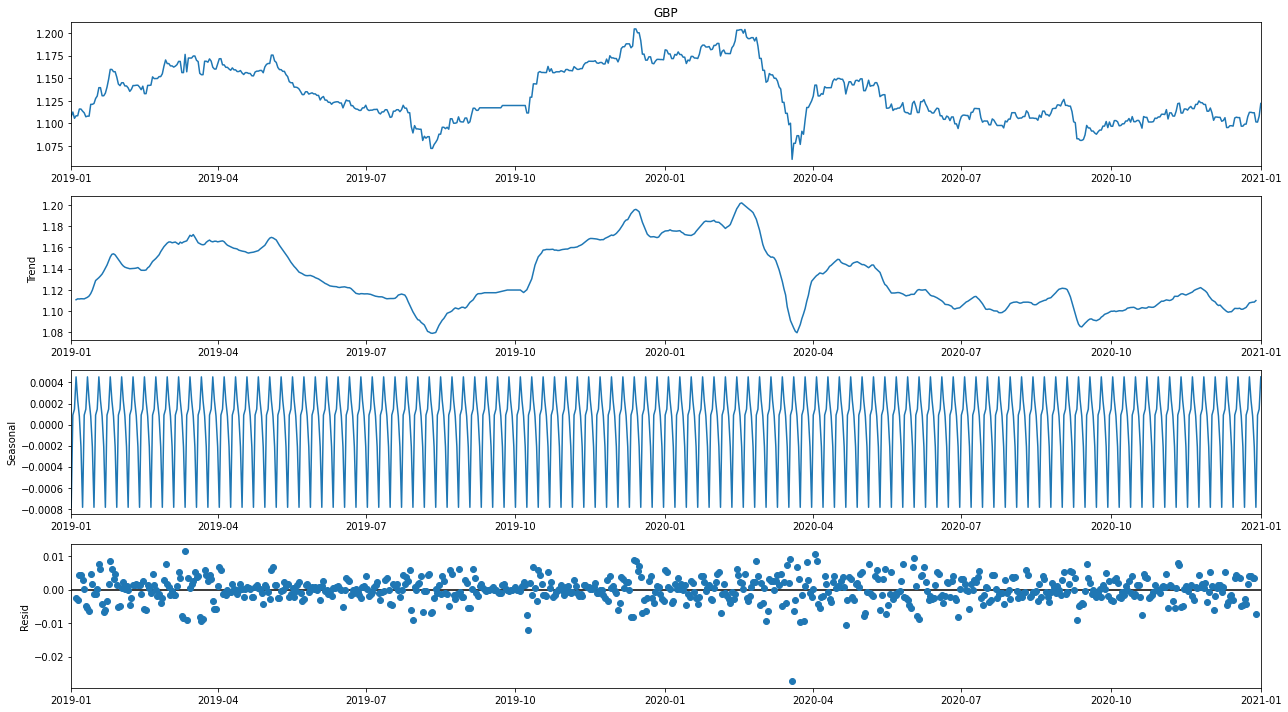

In [13]:
_ = plt.figure(figsize(18,10))
_ = sm.tsa.seasonal_decompose(currency_data.GBP).plot()
print("Dickey-Fuller criterion p=%f" % sm.tsa.stattools.adfuller(currency_data.GBP)[1])

Dickey-Fuller criterion: p=0.000000


<Figure size 1080x720 with 0 Axes>

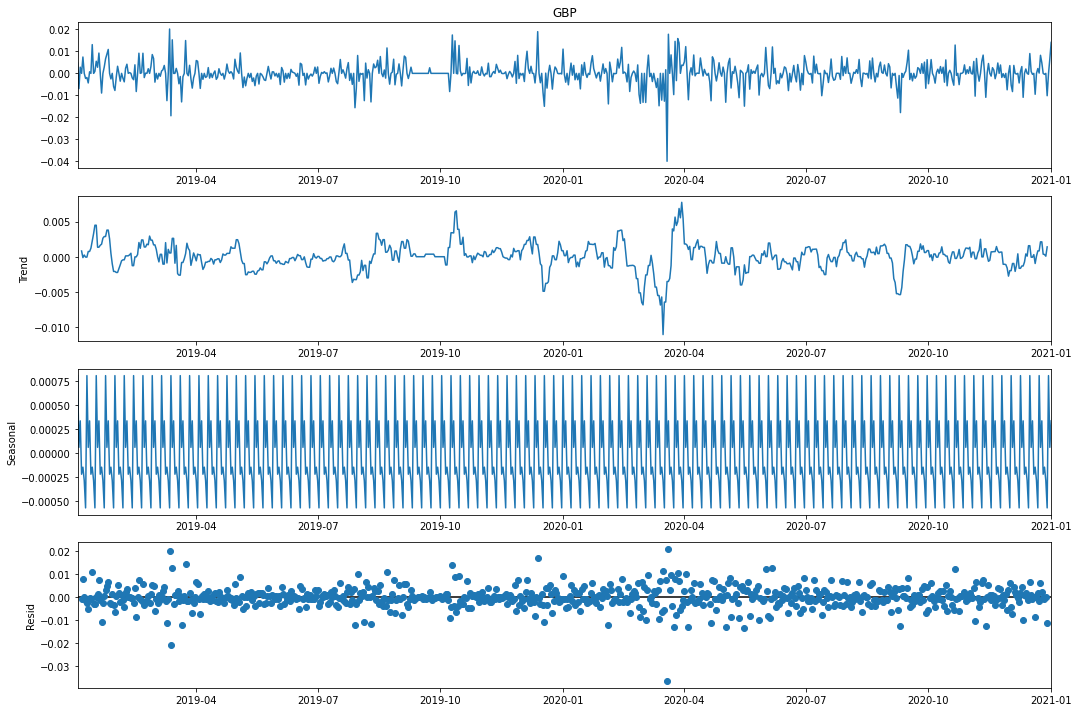

In [15]:
difference_row = currency_data.GBP.diff(periods=1).dropna()
_ = plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(difference_row).plot()
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(difference_row)[1])

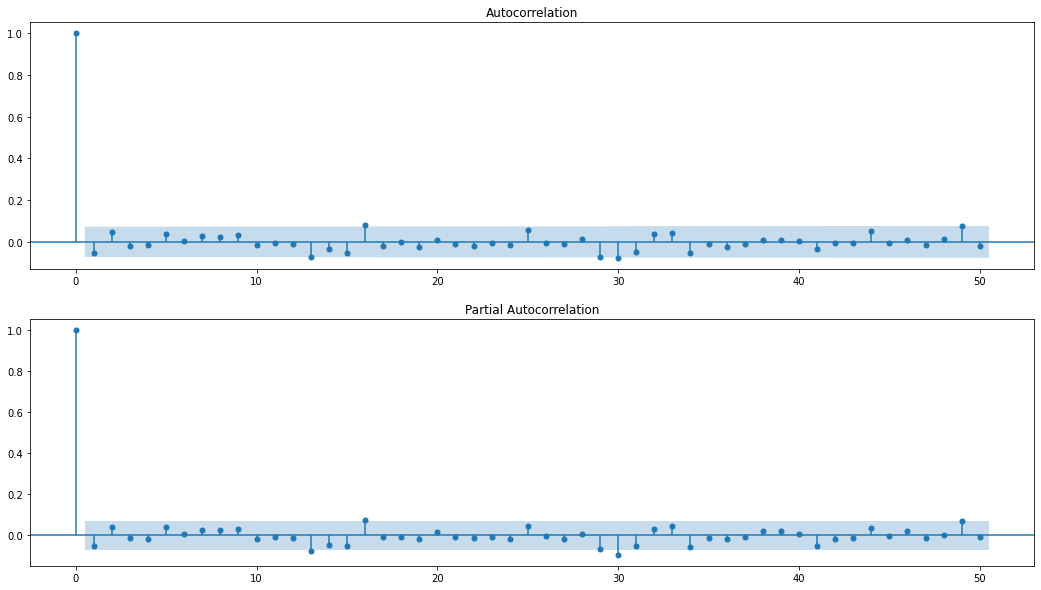

In [16]:
_ = plt.figure(figsize(18,10))
ax_1 = plt.subplot(2,1,1)
_ = sm.graphics.tsa.plot_acf(difference_row.values.squeeze(), lags=50, ax=ax_1)
ax_2 = plt.subplot(2,1,2)
_ = sm.graphics.tsa.plot_pacf(difference_row.values.squeeze(), lags=50, ax=ax_2)

In [ ]:
_ = plt.figure(figsize(18,10))
ax_1 = plt.subplot(2,1,1)
_ = sm.graphics.tsa.plot_acf(difference_row.values.squeeze(), lags=50, ax=ax_1)
ax_2 = plt.subplot(2,1,2)
_ = sm.graphics.tsa.plot_pacf(difference_row.values.squeeze(), lags=50, ax=ax_2)

In [17]:
d = 1
ps = list(range(12))
qs = list(range(12))

In [18]:

parameters_list = list(itertools.product(ps, qs))

In [19]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:

    try:
        model=sm.tsa.statespace.SARIMAX(currency_data, 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(0, 0, 0, 0)).fit(disp=-1)
    
    except ValueError:
        print('wrong paramaters for model:', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1min 11s


In [20]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

    parameters          aic
12      (1, 0) -5675.139810
0       (0, 0) -5675.071745
1       (0, 1) -5674.971188
24      (2, 0) -5674.497699
2       (0, 2) -5674.423483
..         ...          ...
141    (11, 9) -5642.818287
130   (10, 10) -5642.555968
138    (11, 6) -5641.072899
142   (11, 10) -5640.462732
143   (11, 11) -5637.251632

[144 rows x 2 columns]


C:\Users\nigel\anaconda3\envs\jupyterlab\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    GBP   No. Observations:                  732
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2839.570
Date:                Thu, 22 Apr 2021   AIC                          -5675.140
Time:                        21:36:49   BIC                          -5665.951
Sample:                    01-01-2019   HQIC                         -5671.595
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0534      0.027     -2.012      0.044      -0.105      -0.001
sigma2      2.475e-05   5.98e-07     41.412      0.000    2.36e-05    2.59e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

C:\Users\nigel\anaconda3\envs\jupyterlab\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
selected_model = sm.tsa.statespace.SARIMAX(currency_data, order=(11, d, 9), seasonal_order=(0, 0, 0, 0)).fit(disp=-1)

C:\Users\nigel\anaconda3\envs\jupyterlab\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0, 0.5, 'Residuals')

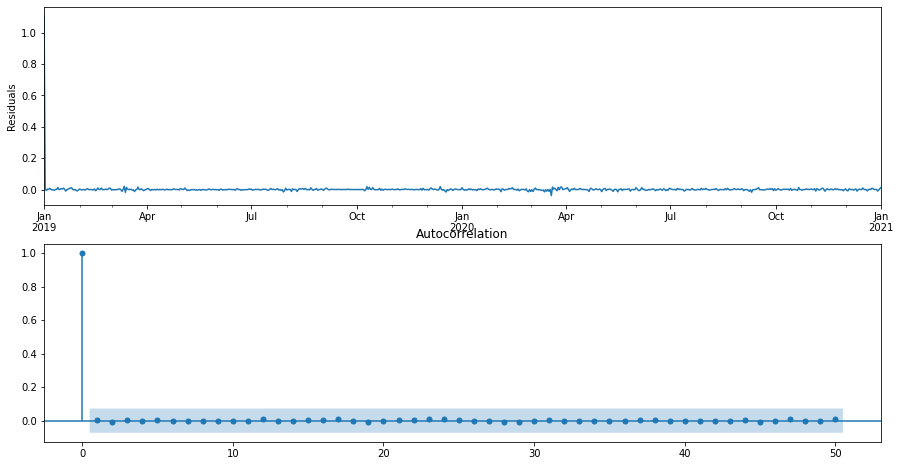

Student's t-test: p=0.315176
Dickey-Fuller criterion: p=0.000000


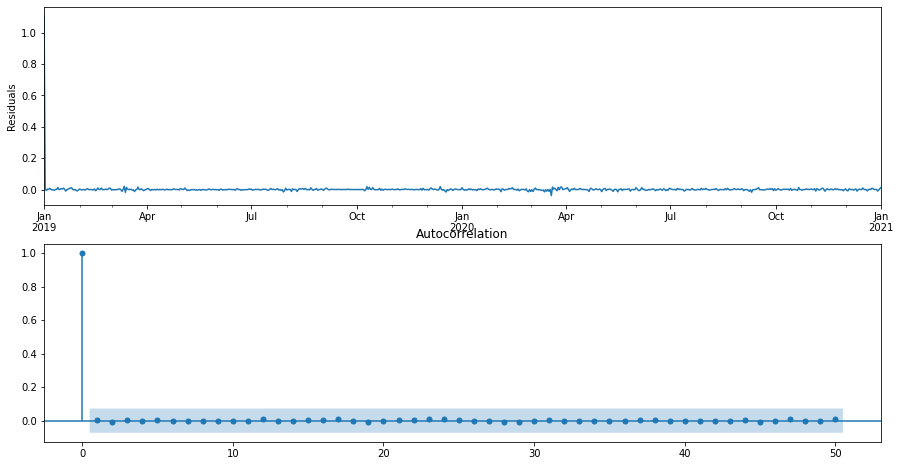

In [23]:
plt.figure(figsize(15,8))
plt.subplot(211)
selected_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(selected_model.resid.values.squeeze(), lags=50, ax=ax)

print("Student's t-test: p=%f" % stats.ttest_1samp(selected_model.resid, 0)[1])
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(selected_model.resid)[1])

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

C:\Users\nigel\anaconda3\envs\jupyterlab\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
def plotARIMA(series, model, n_steps, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted ARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][d:], data['arima_model'][d:])
    

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);

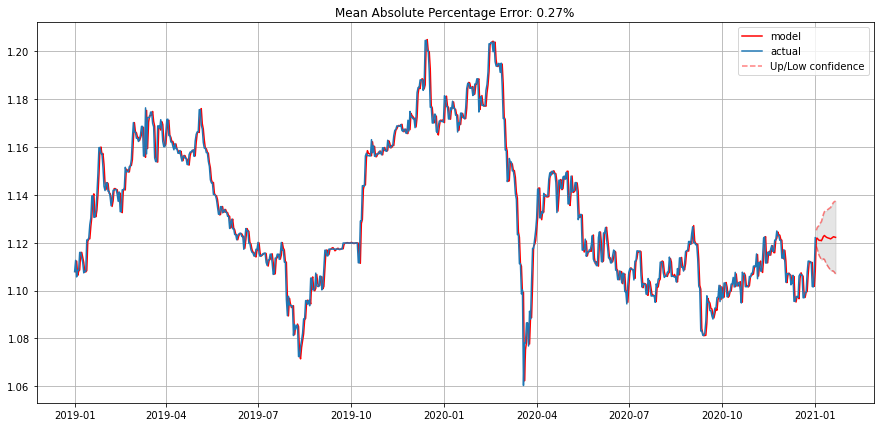

In [31]:
plotARIMA(currency_data, selected_model, 20, alpha=0.5)